# 使用cuFFT库进行快速傅里叶变换

在本部分，我们将使用cuFFT库实现快速傅里叶变换，运用快速傅里叶变换进行图像卷积，实现对图像的高斯滤波。

In [14]:
from __future__ import division
import pycuda.autoinit
from pycuda import gpuarray
import numpy as np
from skcuda import fft
import pycuda.driver as cuda
from skcuda import linalg
from matplotlib import pyplot as plt
import tifffile as tiff
import warnings
warnings.filterwarnings('ignore')
import os

定义卷积操作以及卷积核。

In [16]:
def cufft_conv(x, y):
    """
    使用CUDA FFT在GPU上执行两个数组的卷积。

    参数：
    x (ndarray): 第一个输入数组。
    y (ndarray): 第二个输入数组。

    返回：
    ndarray: 卷积结果。如果输入数组形状不匹配，返回-1。
    """
    x = x.astype(np.complex64)
    y = y.astype(np.complex64)

    if x.shape != y.shape:
        return -1

    plan = fft.Plan(x.shape, np.complex64, np.complex64)
    inverse_plan = fft.Plan(x.shape, np.complex64, np.complex64)

    x_gpu = gpuarray.to_gpu(x)
    y_gpu = gpuarray.to_gpu(y)

    x_fft = gpuarray.empty_like(x_gpu)
    y_fft = gpuarray.empty_like(y_gpu)
    out_gpu = gpuarray.empty_like(x_gpu)

    fft.fft(x_gpu, x_fft, plan)
    fft.fft(y_gpu, y_fft, plan)

    # 在频域中进行乘法
    linalg.multiply(x_fft, y_fft, overwrite=True)

    # 执行逆FFT，并进行缩放
    fft.ifft(y_fft, out_gpu, inverse_plan, scale=True)

    return np.real(out_gpu.get()).astype(np.float32)  # 保留实数部分


def conv_2d(ker, img):
    """
    执行二维卷积操作，使用FFT加速。

    参数：
    ker (ndarray): 卷积核（核函数）。
    img (ndarray): 输入图像。

    返回：
    ndarray: 卷积后的图像。
    """
    # 核和图像的尺寸匹配到相同大小
    padded_ker = np.zeros_like(img, dtype=np.float32)
    padded_ker[:ker.shape[0], :ker.shape[1]] = ker

    # FFT 将核中心对齐
    padded_ker = np.roll(padded_ker, -ker.shape[0] // 2, axis=0)
    padded_ker = np.roll(padded_ker, -ker.shape[1] // 2, axis=1)

    # 在频域中卷积
    out_ = cufft_conv(padded_ker, img)

    # 提取结果并裁剪到原图像大小
    output = np.real(out_[ker.shape[0]//2:-ker.shape[0]//2, ker.shape[1]//2:-ker.shape[1]//2]).astype(np.float32)

    return np.clip(output, 0, 1)  # 确保结果在 [0, 1] 范围内


# 定义一个高斯滤波器的匿名函数，计算给定(x, y)点的高斯值
gaussian_filter = lambda x, y, sigma: (1 / np.sqrt(2 * np.pi * (sigma ** 2))) * np.exp(-(x ** 2 + y ** 2) / (2 * (sigma ** 2)))


def gaussian_ker(sigma):
    """
    生成一个二维高斯核。

    参数：
    sigma (int): 高斯核的标准差，决定了模糊的程度。

    返回：
    ndarray: 归一化的二维高斯核。
    """
    # 初始化一个二维数组，大小为(2*sigma + 1) x (2*sigma + 1)
    ker_ = np.zeros((2 * sigma + 1, 2 * sigma + 1))
    
    # 填充高斯核的每个元素
    for i in range(2 * sigma + 1):
        for j in range(2 * sigma + 1):
            # 计算(x, y)相对于核中心的坐标，并应用高斯函数
            ker_[i, j] = gaussian_filter(i - sigma, j - sigma, sigma)
                
    # 计算核元素的总和，用于归一化
    total_ = np.sum(ker_.ravel())
    
    # 归一化核，使其总和为1
    ker_ = ker_ / total_
    
    return ker_

首先，我们从红、绿、蓝三个波段的图像合成RGB彩色图像，并进行展示，将RGB图像保存。

0.0
1.0


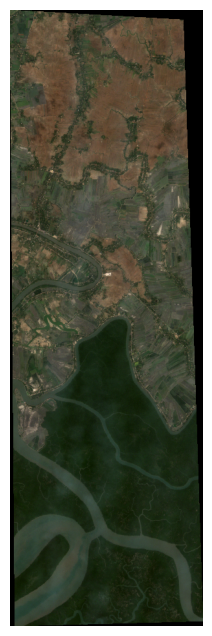

In [2]:
# 读取图像数据
def load_image(image_path):
    img = tiff.imread(image_path)[:,:,0]
    return img.astype(np.float32)

# 图像路径
red_image_path = "/mnt/SundarbansData/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B04_(Raw).tiff"
green_image_path = "/mnt/SundarbansData/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B03_(Raw).tiff"
blue_image_path = "/mnt/SundarbansData/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B02_(Raw).tiff"

# 读取图像
red_image = load_image(red_image_path)
green_image = load_image(green_image_path)
blue_image = load_image(blue_image_path)

# 合成RGB图像
rgb_image = np.dstack((red_image, green_image, blue_image))
rgb_image_normalized = rgb_image/np.max(rgb_image)
print(np.min(rgb_image_normalized))
print(np.max(rgb_image_normalized))

# 显示并保存RGB图像
plt.figure(figsize=(10, 8))
plt.imshow(rgb_image_normalized)
plt.axis('off')  # 去掉坐标轴
plt.savefig("rgb_image.png", dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

接下来，我们对RGB图像的每个通道进行卷积。

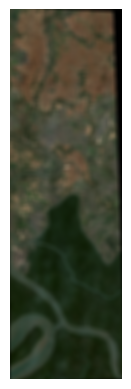

In [23]:
# 读入图片
image = np.float32(plt.imread("/mnt/rgb_image.png"))

# 初始化一个全0数组，用于存储模糊后的图像
image_blurred = np.zeros((1817, 546, 3), dtype=np.float32)

# 生成标准差为15的高斯核
ker = gaussian_ker(15)

# 对图像的每个颜色通道（例如RGB）应用二维卷积
for k in range(3):
    image_blurred[:, :, k] = conv_2d(ker, image[:, :, k])
    
# 展示图像并保存
plt.imshow(image_blurred)
plt.axis('off')  # 去掉坐标轴
plt.savefig("rgb_image_blurred.png", dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()